In [ ]:
from PIL import Image
import torch.nn as nn
import os
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
#All images follow this format Abstract_image_155


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device.type)

# Number of workers for dataloader
workers = 2

# Batch size during training
bs = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 120

# Size of feature maps in discriminator
ndf = 280

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.99


###############
dataset = datasets.ImageFolder(root='G:/My Drive/Colab Notebooks/art77/Abstract_gallery/',
#dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/animals/',
#dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/art77/ag2/',
                              transform=transforms.Compose([
                              transforms.Resize(image_size),
                              transforms.CenterCrop(image_size),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                              ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs,
                                         shuffle=True, num_workers=workers)
#################################


#not used
img_size = 200

print('test')
def noise(bs, nz):

    #Generate random Gaussian noise.

    return Variable(torch.randn(bs, nz, 1, 1))

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is noise size
            #switched from using ReLU to LeakyReLu
            nn.ConvTranspose2d( 100, ngf * 8, 3, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d( ngf * 2, ngf * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d( ngf * 2, nc, 3, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(3, ndf, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(ndf , ndf * 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),


            nn.Conv2d(ndf *4, ndf * 2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 2, 1, 3, 1, 0, bias=False),
            nn.AdaptiveAvgPool2d(1),

            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).squeeze()

class GAN:
    def __init__(self, discriminator, generator, batch_size=1):
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.g_losses = []
        self.d_losses = []
        # Define binary cross entropy loss
        self.loss = nn.BCELoss()

        # Define separate optimizers for discriminator and generator
        self.d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=0.0019)
        self.g_optimizer = torch.optim.Adam(self.generator.parameters(), lr=0.0002)

    def train(self, num_epochs, dataloader, resume=False, checkpoint_path='checkpointC.pth'):
      # Training Loop for each epoch
      start_epoch = 0
      if resume:
        if os.path.isfile(checkpoint_path):
          print(f"=> loading checkpoint '{checkpoint_path}'")
          checkpoint = torch.load(checkpoint_path)
          start_epoch = checkpoint['epoch']
          self.generator.load_state_dict(checkpoint['generator_state_dict'])
          self.discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
          self.g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
          self.d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
          print(f"=> loaded checkpoint '{checkpoint_path}' (epoch {checkpoint['epoch']})")
        else:
            print(f"=> no checkpoint found at '{checkpoint_path}'")

      for epoch in range(start_epoch, num_epochs):
        print ('Going')

        if epoch % 1 == 0:
          print('Generating Samples...')
          # Generate images from noise, using the generator network.
          count = 6
          for i in range(count):

            sample_vectors = noise(bs,100)
            samples = self.generator(sample_vectors)
            save_image(samples, f'G:/My Drive/Colab Notebooks/dandies/new_dandies/ArcwrideC_{epoch}_{i}.png', normalize=True)
            #save_image(samples, f'/content/drive/MyDrive/Colab Notebooks/dandies/new_dandies/Odlud_{epoch}_{i}.png', normalize=True)

            print ('Saved')
            # Batch Loop for each set of images and labels
          for n, (images, _) in enumerate(dataloader):
                current_batch_size = images.size(0)

                real_images = Variable(images)
                #Switched from 1 to using .9 as the target
                real_labels = Variable(torch.full((current_batch_size,), 0.9))





                # Train Discriminator on real images
                self.d_optimizer.zero_grad()
                real_outputs = self.discriminator(real_images)

                d_loss_real = self.loss(real_outputs.squeeze(0), real_labels)
                d_loss_real.backward()

                # Prepare fake images and fake labels
                noise_vectors = noise(self.batch_size, nz)
                fake_images = self.generator(noise_vectors)
                fake_labels = Variable(torch.zeros(current_batch_size, 1)).view(-1)

                # Train Discriminator on real images
                self.d_optimizer.zero_grad()
                real_outputs = self.discriminator(real_images).view(-1).squeeze()
                real_outputs = real_outputs.squeeze()

                d_loss_real = self.loss(real_outputs, real_labels)
                d_loss_real.backward()

                # Prepare fake images and fake labels
                noise_vectors = noise(self.batch_size, nz)
                fake_images = self.generator(noise_vectors)
                fake_labels = Variable(torch.zeros(self.batch_size, 1)).view(-1)

                # Train Discriminator on fake images
                fake_outputs = self.discriminator(fake_images.detach()).view(-1)
                d_loss_fake = self.loss(fake_outputs, fake_labels)
                d_loss_fake.backward()

                # Update Discriminator weights
                self.d_optimizer.step()
                #self.d_losses.append(d_loss_real+d_loss_fake.item())

                # Train Generator to fool the Discriminator
                self.g_optimizer.zero_grad()
                noise_vectors = noise(self.batch_size, nz)
                fake_images = self.generator(noise_vectors)
                outputs = self.discriminator(fake_images).view(-1)

                # We train the generator to generate images that the discriminator will think are real
                g_loss = self.loss(outputs, Variable(torch.ones(self.batch_size)).view(-1))
                g_loss.backward()

                # Update Generator weights
                self.g_optimizer.step()
                self.g_losses.append(g_loss.item())

                if (n+1) % 1 == 0:
                    print(f'Epoch {epoch+1}/{num_epochs}, Step {n+1}, d_loss: {d_loss_real+d_loss_fake}, g_loss: {g_loss}')
                    torch.save({
                    'epoch': epoch,
                    'generator_state_dict': gan.generator.state_dict(),
                    'discriminator_state_dict': gan.discriminator.state_dict(),
                    'g_optimizer_state_dict': gan.g_optimizer.state_dict(),
                    'd_optimizer_state_dict': gan.d_optimizer.state_dict(),
                    'g_loss': g_loss,
                    'd_loss': d_loss_fake
                    }, 'checkpointC.pth')


generator = Generator()
discriminator = Discriminator()

gan = GAN(discriminator, generator)
gan.train(2000, dataloader, resume=True)

cpu
test
=> loading checkpoint 'checkpointC.pth'
=> loaded checkpoint 'checkpointC.pth' (epoch 91)
Going
Generating Samples...
Saved
Saved
Saved
Saved
Saved
Saved
Epoch 92/2000, Step 1, d_loss: 0.3454250395298004, g_loss: 4.630792617797852
Epoch 92/2000, Step 2, d_loss: 0.36729857325553894, g_loss: 5.792097091674805
Epoch 92/2000, Step 3, d_loss: 0.3931560218334198, g_loss: 5.037808418273926
Epoch 92/2000, Step 4, d_loss: 0.4994896650314331, g_loss: 4.085577487945557
Epoch 92/2000, Step 5, d_loss: 0.37737131118774414, g_loss: 3.9561519622802734
Epoch 92/2000, Step 6, d_loss: 0.35775595903396606, g_loss: 3.5633347034454346
Epoch 92/2000, Step 7, d_loss: 0.38570278882980347, g_loss: 3.839994430541992
Epoch 92/2000, Step 8, d_loss: 0.39342570304870605, g_loss: 3.4786500930786133
Epoch 92/2000, Step 9, d_loss: 0.40222984552383423, g_loss: 4.313447952270508
Epoch 92/2000, Step 10, d_loss: 0.3964149057865143, g_loss: 2.850257635116577
Epoch 92/2000, Step 11, d_loss: 0.3594900369644165, g_los

In [ ]:
import torch
torch.cuda.is_available()

False

NameError: ignored

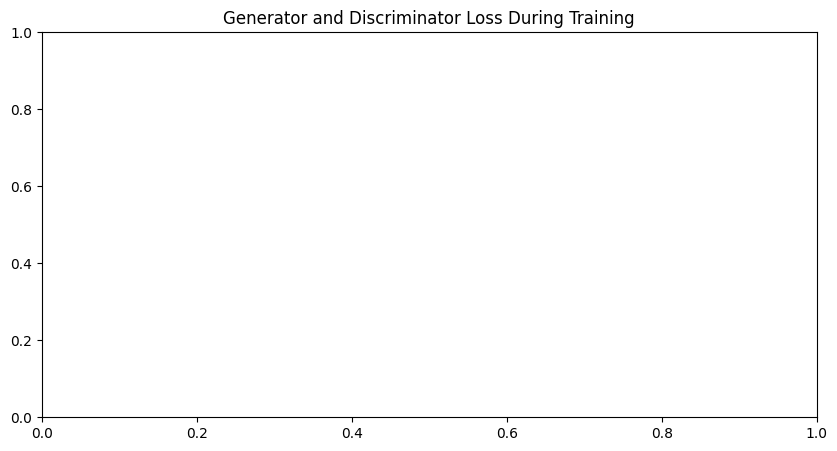

In [ ]:

#Visualize the generator and discriminator losses over epochs
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
sns.lineplot(data=gan.g_losses, label="G")
sns.lineplot(data=gan.d_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()